# Cyclical Chemical Reactions
Inspired by reading about the Krebs Cycle and how it's like a roundabout with molecules leaving and joining all over the place, rather than a closed cycle, I thought I'd do a quick model of what that is like so I can get a feel for the dynamics.

We'll start with 4 species, a, b, c, and d, and their concentrations A, B, C, and D. Each species reacts to form the subsequent one in the sequence and has some exogenous (outside the cycle) source or sink. So each species is has three flows, generation from its precursor, exogenous influx, and transformation into its successor. If we represent the fluxes with $\phi$, then we have:

$$ \frac{dA}{dt} = \dot{A} = \phi_{da} + \phi_a - \phi_{ab} $$

If we assume for the time being that reaction rate depends only on the concentration of the precursor, then we have:

$$ \phi_{xy} = k_{xy}X $$

If we further assume that the exogenous flux is a linear stabilising buffer around some quiescent concentration $\bar{X}$, then we have:

$$ \phi_x = k_x(X - \bar{X}) $$

where we'd expect $k_x$ to be negative in any stable system. Putting that together then, we have:

$$ \dot{A} = k_{da}D + k_a(A - \bar{A}) - k_{ab}A $$

and so on for the other species. Putting this in matrix form gives an expression for the vector of concentration changes in terms of the concentrations and their quiescent points:

In [1]:
import numpy as np

# let's have some reaction rate constants:
k_a = k_b = k_c = k_d = 0#-0.1
k_ab = k_bc = k_cd = k_da = 0.1
# k_ab = 0.2

# some quiescent concentrations:
Abar = Bbar = Cbar = Dbar = 1

# and some initial concentrations:
A = B = C = D = 1.0
B = 1.5

# So relationships between concentrations are:
K = np.array([[k_a  - k_ab, 0         , 0         , k_da      ],
              [k_ab       , k_b - k_bc, 0         , 0         ],
              [0          , k_bc      , k_c - k_cd, 0         ],
              [0          , 0         , k_cd      , k_d - k_da]])

# and the buffer equations:
Kbuff = np.array([[-k_a*Abar],[-k_b*Bbar],[-k_c*Cbar],[-k_d*Dbar]])

# which together give the dynamics:
Kp = np.append(K, Kbuff, 1)

# So we start from state X:
X = np.array([A, B, C, D])
Xdot = Kp @ np.append(X, 1)

print(X)
print(Xdot)


[1.  1.5 1.  1. ]
[ 0.   -0.05  0.05  0.  ]


In [2]:
def integration_step(X, K, dt=1):
    """ Integrate the system one step forward in time."""
    Xdot = K @ np.append(X, 1)
    X += Xdot * dt
    return X

def loop_flux(K, X):
    """ Calculate the flux through the loop, as distinct from the temporary fluxes between species."""
    # return np.min(np.diag(np.roll(K, -1, axis=0)) * X)
    return np.diag(np.roll(K, -1, axis=0)) * X

In [3]:
# Now we can integrate the system forward in time:
Xhistory = np.zeros((0, 4))
PhiL = np.zeros((0, 4))
tEnd = 60
dt = 0.1
t = np.arange(0, tEnd, dt)
for time in t:
    Xhistory = np.append(Xhistory, [X.copy()], 0)
    X = integration_step(X, Kp, dt)
    PhiL = np.append(PhiL, [loop_flux(K, X)], 0)

print(t.shape)
print(Xhistory.shape)
print(PhiL.shape)



(600,)
(600, 4)
(600, 4)


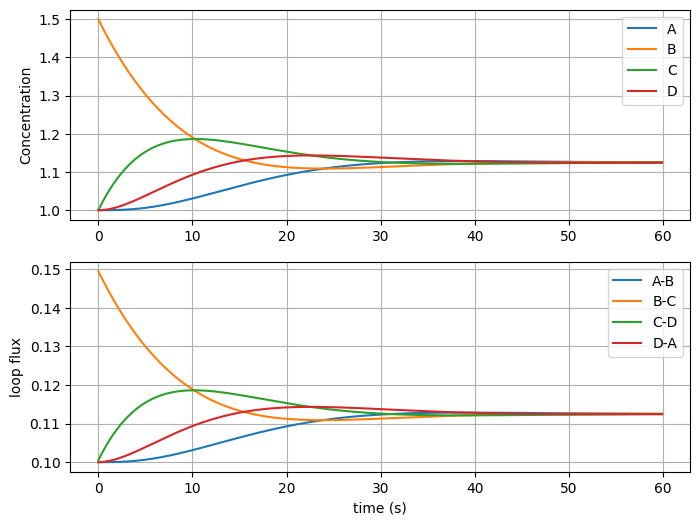

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# plot each row as a line
labels = ['A', 'B', 'C', 'D']
for i in range(Xhistory.shape[1]):
    ax1.plot(t, Xhistory[:,i], label=labels[i])
    # ax2.plot(t[:-1], Xhistory[:-1,i] - Xhistory[1:,i], label=labels[i])
    ax2.plot(t, PhiL[:,i], label=f"{labels[i]}-{labels[(i+1)%len(labels)]}")


# show the plot
ax1.legend()
ax1.set_ylabel('Concentration')
ax1.grid()

ax2.legend()
ax2.set_xlabel('time (s)')
ax2.set_ylabel('loop flux')
ax2.grid()

plt.show()